# Load libraries

In [1]:
import pandas as pd
import numpy as np
import os
import dateutil
import pytz
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime, timedelta
from tqdm import tqdm

pd.options.mode.chained_assignment = None

# Load Data

In [2]:
flights = pd.read_csv('/kaggle/input/us-flights-data-2008/2008.csv')
flights.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


In [3]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       float64
 25  WeatherDelay      

# Data preparation

For our task we will only need date and time, origin and destination airports, departure and arrival time. So we are interested in the following columns:
- Year
- Month
- DayofMonth
- CRSDepTime - scheduled departure time (local, hhmm, integer)
- CRSArrTime - scheduled arrival time (local, hhmm, integer)
- Origin - origin IATA airport code
- Dest - destination IATA airport code

Since time is given in a local timezone, we will extract timezones from [here](https://raw.githubusercontent.com/hroptatyr/dateutils/tzmaps/iata.tzmap) and use them while converting to utc datetime.

Also, we decide that DayofMonth is a day of flight's departure so we need to control for night flights.

In [4]:
# Getting airports' timezone information
airport_tz = pd.read_fwf('https://raw.githubusercontent.com/hroptatyr/dateutils/tzmaps/iata.tzmap', names=['code', 'tz'], colspecs=[(0, 3), (3, None)])
#
# make sure that all airports in our dataset are present
airports = pd.Series(flights['Origin'].unique())
codes = airport_tz.code.unique()
bad = [ap not in codes for ap in airports]
for a in airports[bad]:
    print(a)

PFN


[PFN](https://en.wikipedia.org/wiki/Panama_City%E2%80%93Bay_County_International_Airport) is closed airport in Panama City, Florida. It has timezone America/Chicago. So we will augment `airport_tz` dataset with a new entry:

In [5]:
# Add time the airport timezone
airport_tz.loc[len(airport_tz.index)] = ['PFN', 'America/Chicago']
# Make code index
airport_tz = airport_tz.set_index('code')
# show tail
airport_tz.tail(2)

,tz
code,
ZZV,America/New_York
PFN,America/Chicago


In [6]:
flights[['CRSDepTime', 'CRSArrTime']].describe()

,CRSDepTime,CRSArrTime
count,7.009728e+06,7.009728e+06
mean,1.326086e+03,1.494801e+03
std,4.642509e+02,4.826728e+02
min,0.000000e+00,0.000000e+00
25%,9.250000e+02,1.115000e+03
50%,1.320000e+03,1.517000e+03
75%,1.715000e+03,1.907000e+03
max,2.359000e+03,2.400000e+03


Time is given as integer, also we see that CRSArrTime equals 2400, which assumably is 00:00 next day, for simplicity we will change it to 23:59 of the day.

In [7]:
def to_time(int_var):
    """
    Returns time recorded as integer and format it as time (24h) in string format.
    Examples:
    1 -> 00:01
    41 -> 00:41
    537 -> 05:37
    1714 -> 17:14
    """
    str_var = str(int_var).rjust(4, '0')
    return str_var[:2] + ':' + str_var[2:]

@np.vectorize
def get_tz(code):
    """
    Returns time zone as dateutil.tz.tz.tzfile from airport code
    """
    tz = dateutil.tz.gettz(airport_tz.loc[code, 'tz'])
    return tz

@np.vectorize
def to_datetime(year, month, day, time, tz):
    """
    Returns datatime in UTC
    """
    h, m = time.split(sep=':')
    result = datetime(year, month, day, int(h), int(m), tzinfo=tz).astimezone(pytz.utc)#.replace(tzinfo=None)
    return result
    #return np.datetime64(result)

def preprocess(df):
    
    # replace 24:00 with 23:53
    df.loc[df['CRSArrTime'] >= 2400, 'CRSArrTime'] = 2359
    df.loc[df['CRSDepTime'] >= 2400, 'CRSArrTime'] = 2359
    
    # create column with departure and arrival time as string
    df['arr_time'] = df['CRSArrTime'].apply(to_time)
    df['dep_time'] = df['CRSDepTime'].apply(to_time)
    
    # create datetime columns
    df['arr_datetime'] = to_datetime(df['Year'], df['Month'], df['DayofMonth'], df['arr_time'], get_tz(df['Dest']))
    df['dep_datetime'] = to_datetime(df['Year'], df['Month'], df['DayofMonth'], df['dep_time'], get_tz(df['Origin']))
    
    # leave only relevant columns 
    result = df[['dep_datetime', 'Origin', 'arr_datetime', 'Dest']]

    # rename columns
    result.columns = ['departure', 'origin', 'arrival', 'dst']
    
    # control for night flights
    result.loc[result['departure'] > result['arrival'], 'arrival'] += timedelta(hours=24)

    # sort by departure time
    result.sort_values('departure', inplace=True)
    
    return result

Dataset is very big, so we will take only one month to work with.

In [8]:
!rm dataset.csv

rm: cannot remove 'dataset.csv': No such file or directory


In [9]:
selected_month = 6
dataset_path = 'dataset.csv'
if os.path.exists(dataset_path):
    flights_1m = pd.read_csv(dataset_path)
else:
    flights_1m = flights[flights.Month == selected_month]
    flights_1m.to_csv('dataset.csv', index=False)
flights_1m.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
2995510,2008,6,2,1,1956.0,1955,2050.0,2055,WN,34,...,2.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2995511,2008,6,2,1,1032.0,1030,1132.0,1130,WN,1061,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2995512,2008,6,2,1,1401.0,1355,1456.0,1455,WN,1462,...,5.0,6.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2995513,2008,6,2,1,1154.0,1155,1249.0,1255,WN,1843,...,5.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2995514,2008,6,2,1,828.0,830,928.0,930,WN,2018,...,5.0,12.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


In [10]:
!rm prepared.csv

rm: cannot remove 'prepared.csv': No such file or directory


In [11]:
prepared_path = 'prepared.pkl'
if os.path.exists(prepared_path):
    df = pd.read_pickle(prepared_path)
else:
    df = preprocess(flights_1m).reset_index(drop=True)
    df.to_pickle(prepared_path)
df.head()

,departure,origin,arrival,dst
0,2008-06-01 04:40:00+00:00,MCO,2008-06-01 07:26:00+00:00,SJU
1,2008-06-01 05:45:00+00:00,SJU,2008-06-01 09:33:00+00:00,JFK
2,2008-06-01 06:01:00+00:00,SLC,2008-06-01 10:29:00+00:00,JFK
3,2008-06-01 06:35:00+00:00,SLC,2008-06-01 09:59:00+00:00,ATL
4,2008-06-01 06:50:00+00:00,DEN,2008-06-01 09:33:00+00:00,ATL


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608665 entries, 0 to 608664
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype              
---  ------     --------------   -----              
 0   departure  608665 non-null  datetime64[ns, UTC]
 1   origin     608665 non-null  object             
 2   arrival    608665 non-null  datetime64[ns, UTC]
 3   dst        608665 non-null  object             
dtypes: datetime64[ns, UTC](2), object(2)
memory usage: 18.6+ MB


In [13]:
df = pd.read_pickle('prepared.pkl')

# Simulation

In [14]:
initial_dt = to_datetime([2008], [6], [1], ['00:00'], [pytz.utc])[0]
def do_simulation(airport, p, debug=False):
    """
    Run infection spreading simulation
    :param airport: str
        airport code of initially infected airport
    :param p: float
        probability of a new airport being infected
    :param debug: bool, default False
        If True print debugging information
    :return: dict
        dictionary of infection spreading. datetime as a key and airport code as data.
    """
    infected = [airport]
    results = {airport: initial_dt}

    for row in df.itertuples():
        chance = np.random.uniform()
        # origin infected, dst is not infected yet and checking probability of infection
        if (row.origin in infected) and (row.dst not in infected) and (chance <= p):
            # control for flights which should not be infected yet 
            #(infection flight arrival is in future in comparison to departure flights to other airports)
            if results[row.origin] > row.departure:
                if debug:
                    print('too early!', row)
                continue
            if debug:
                print('Infected!!', row)
            infected.append(row.dst)
            results[row.dst] = row.arrival
        else:
            continue
    return results

Test run of the infection spread simulation.

In [15]:
# number of airports
N = len(df['origin'].unique())
p = 0.01
airport = 'ABE'
print('Starting airport:', airport)
np.random.seed(7)
res = do_simulation(airport, p)
print(f'Infected in a month: {len(res)}/{N}')

Starting airport: ABE
Infected in a month: 239/293


## How contagious infection must be to afflict all of the airports?

In [16]:
def run_simulations(airport, probs, n, debug=False):
    results = pd.DataFrame(columns=['p', 'sim_id', 'airport', 'infected'])
    for p in probs:
        print('simulations for p =', p)
        for i in tqdm(range(n)):
            # run simulation
            sim_res = pd.DataFrame.from_dict(do_simulation(airport, p), orient='index').reset_index()
            sim_res.columns = ['airport', 'infected']
            sim_res['sim_id'] = i
            sim_res['p'] = p
            results = pd.concat([results, sim_res]) 
    return results

In [17]:
# List of probabilities
probs = [0.01, 0.05, 0.1, 0.5, 1]
# number of simulations
n_sim = 10
# fix seed
np.random.seed(7)
print('Starting airport:', airport)
# DataFrame for results
results_df = run_simulations(airport, probs, n_sim)#pd.DataFrame(columns=['p', 'sim_id', 'airport', 'infected'])
results_df.to_pickle('results.pkl')

Starting airport: ABE
simulations for p = 0.01


100%|██████████| 10/10 [00:58<00:00,  5.88s/it]


simulations for p = 0.05


100%|██████████| 10/10 [01:02<00:00,  6.29s/it]


simulations for p = 0.1


100%|██████████| 10/10 [01:04<00:00,  6.44s/it]


simulations for p = 0.5


100%|██████████| 10/10 [01:05<00:00,  6.51s/it]


simulations for p = 1


100%|██████████| 10/10 [01:04<00:00,  6.44s/it]


In [18]:
# Dataset time boundaries
min_time = df['departure'].min()
max_time = df['arrival'].max()
print(f'From {min_time} to {max_time}')

# dictionary to record results
tsim_res = dict()

# time delta
dt = timedelta(hours=12)

# time point
tp = min_time
while tp < max_time:
    infected_pct = results_df[results_df.infected <= tp].groupby(['p', 'sim_id']).size()/N
    infected_pct = infected_pct.reset_index().groupby('p')[0].mean()
    tsim_res[tp] = infected_pct
    tp += dt

From 2008-06-01 04:40:00+00:00 to 2008-07-01 15:30:00+00:00


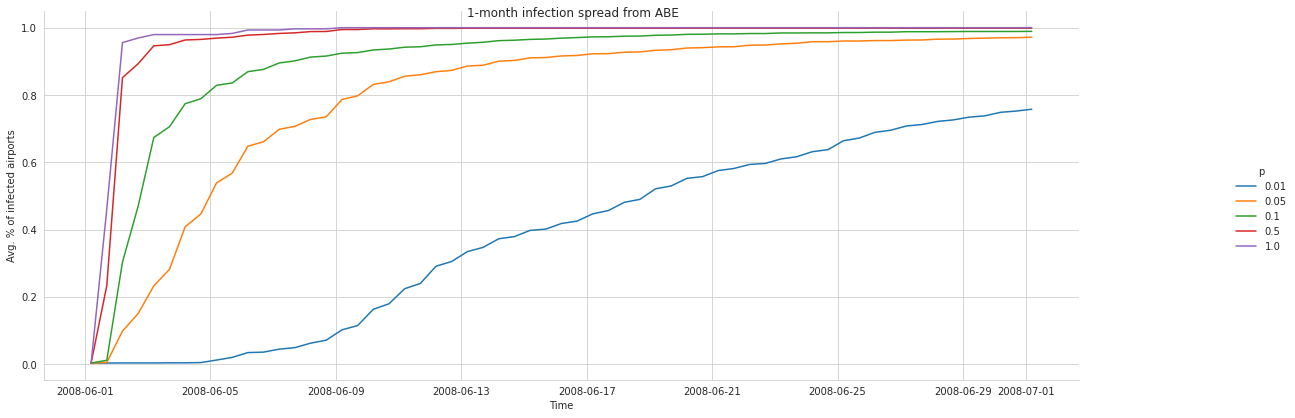

In [19]:
# Creating dataframe for visualisation
data_viz = pd.DataFrame.from_dict(tsim_res, orient='index')
data_viz = data_viz.reset_index().melt(id_vars='index', var_name='p')
data_viz['p'] = data_viz.p.astype('category')
# Visualising
sns.set_style('whitegrid')
lp = sns.relplot(data=data_viz, kind='line', x='index', y='value', hue='p')
lp.fig.set_figwidth(20)
lp.fig.set_figheight(6)
lp.fig.suptitle(f'1-month infection spread from {airport}')
lp.ax.set_xlabel('Time')
lp.ax.set_ylabel('Avg. % of infected airports')
plt.show()


## Could information about airport network help with predictions about infection spread?
1. Create undirected graph of flights with weights equal to sum of flights between airports divided by overall number of flights.
1. Compute *clustering coefficient*, *degree* and *shortest-path betweenness centrality* for each of the nodes (airports).
1. Run simulation 50 times with p = 0.5
1. Calculate median time of infection spread to each of the airports
1. Investigate relationship between median time and metrics calculated from graph

### Building graph

In [20]:
@np.vectorize
def combine_orig_dst(origin, dst):
    """
    Combine airport codes in aphabetical order
    """
    if origin < dst:
        result = f'{origin} {dst}'
    else:
        result = f'{dst} {origin}'
    return result

In [21]:
# Number of flights
NF = df.shape[0]

# Create edgelist from dataframe
df['edge'] = combine_orig_dst(df.origin, df.dst)
edgelist = df.groupby('edge').size()/NF
edgelist = edgelist.reset_index()
edgelist[['node1', 'node2']] = edgelist['edge'].str.split(' ', 1, expand=True)
edgelist = edgelist[['node1', 'node2', 0]]
edgelist.columns = ['node1', 'node2', 'weight']
edgelist.to_csv('edgelist.csv', header=False, index=False, sep=' ')
edgelist

,node1,node2,weight
0,ABE,ATL,0.000197
1,ABE,CLE,0.000196
2,ABE,CLT,0.000099
3,ABE,CVG,0.000112
4,ABE,DTW,0.000292
...,...,...,...
2348,STL,TPA,0.000296
2349,STL,TUL,0.000283
2350,SWF,TPA,0.000099
2351,TLH,TPA,0.000261


In [22]:
# Create graph
ag = nx.read_weighted_edgelist('edgelist.csv', nodetype=str)
print(ag.number_of_nodes(), 'nodes and ', ag.number_of_edges(), 'edges in the graph')

293 nodes and  2353 edges in the graph


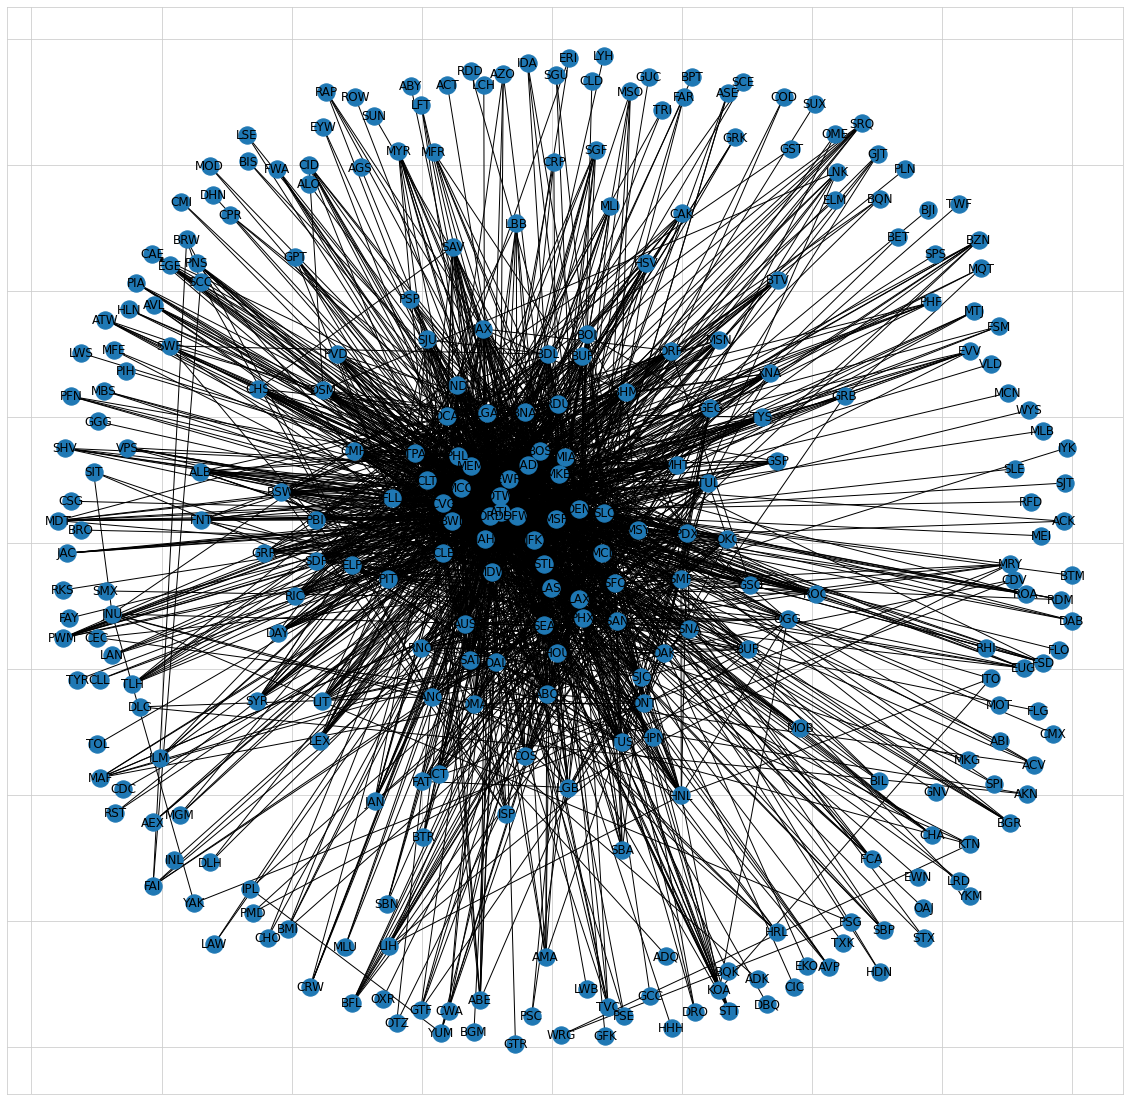

In [23]:
fig = plt.figure(1, figsize=(20, 20))
nx.draw_networkx(ag)

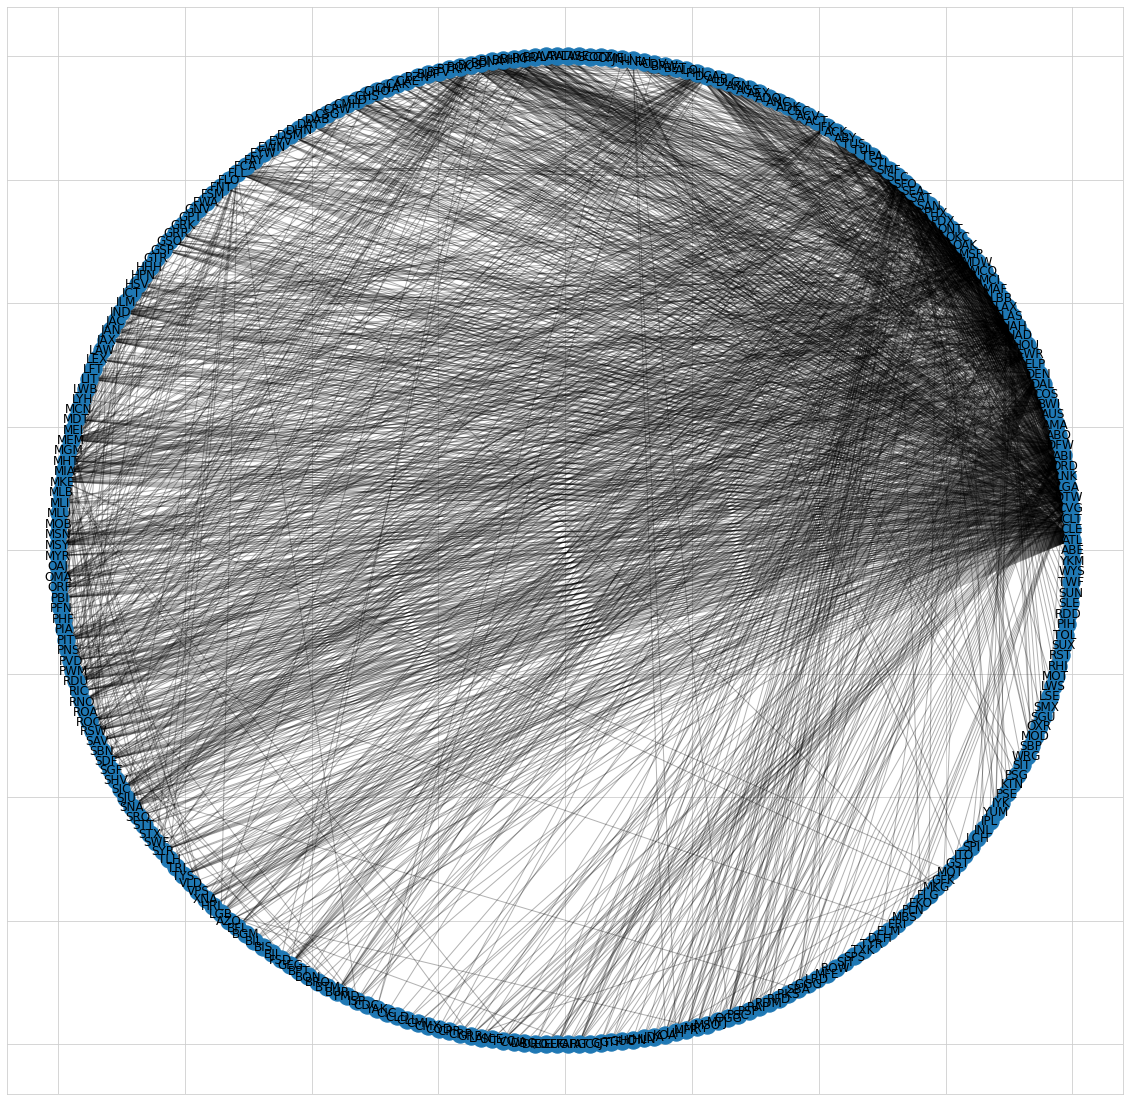

In [24]:
fig = plt.figure(1, figsize=(20, 20))
pos=nx.circular_layout(ag)
nx.draw_networkx_nodes(ag,pos=pos)
nx.draw_networkx_edges(ag,pos=pos,alpha=0.3)
nx.draw_networkx_labels(ag, pos=pos)
plt.show()

### Calculating node metrics

In [25]:
clustering = nx.clustering(ag, weight='weight')
degree = dict(ag.degree(weight='weight'))
centrality = nx.betweenness_centrality(ag, weight='weight')

In [26]:
# Combine metrics to DataFrame
node_metrics = pd.DataFrame.from_dict(clustering ,orient='index', columns=['clustering']).join([
    pd.DataFrame.from_dict(degree ,orient='index', columns=['degree']),
    pd.DataFrame.from_dict(centrality ,orient='index', columns=['centrality'])
])
node_metrics.head()

,clustering,degree,centrality
ABE,0.053657,0.001285,0.085946
ATL,0.025138,0.116363,0.154918
CLE,0.037896,0.019957,0.061712
CLT,0.055346,0.034954,0.052054
CVG,0.024096,0.026282,0.142494


In [27]:
node_metrics.sort_values('clustering', ascending=False)

,clustering,degree,centrality
MOD,0.211753,0.000803,0.000000
MFE,0.185679,0.001097,0.000000
RST,0.174956,0.000872,0.000000
PSC,0.172477,0.000772,0.000000
LAW,0.171386,0.000859,0.000000
...,...,...,...
RFD,0.000000,0.000023,0.000000
EWN,0.000000,0.000199,0.000000
CDC,0.000000,0.000182,0.000000
YAK,0.000000,0.000197,0.010015


In [28]:
node_metrics.describe()

,clustering,degree,centrality
count,293.000000,293.000000,293.000000
mean,0.059389,0.006826,0.017711
std,0.046538,0.014552,0.044180
min,0.000000,0.000012,0.000000
25%,0.007816,0.000396,0.000000
50%,0.061655,0.001396,0.000000
75%,0.087101,0.004924,0.006849
max,0.211753,0.116363,0.315260


### Running simulation

In [29]:
np.random.seed(77)
results_50 = run_simulations('ABE', [0.5], 50)
results_50.to_pickle('sim50res.pkl')

simulations for p = 0.5


100%|██████████| 50/50 [05:34<00:00,  6.70s/it]


In [30]:
results_50 = results_50.reset_index(drop=True)
# Starting time
st = results_50.loc[0, 'infected']
st
# Calculate time before infection (dt)
results_50['dt'] = results_50['infected'] - st
# Calculate median time
median_time = results_50.groupby('airport')['dt'].median()
assert median_time.isna().sum() == 0


In [31]:
# Join median time with node metrics
ap_metrics = node_metrics.join(median_time)
# Convert timedelta to hours
ap_metrics['hours'] = ap_metrics['dt'].dt.seconds/60/60
ap_metrics.head()

,clustering,degree,centrality,dt,hours
ABE,0.053657,0.001285,0.085946,0 days 00:00:00,0.000000
ATL,0.025138,0.116363,0.154918,0 days 14:37:00,14.616667
CLE,0.037896,0.019957,0.061712,0 days 16:45:00,16.750000
CLT,0.055346,0.034954,0.052054,0 days 14:30:00,14.500000
CVG,0.024096,0.026282,0.142494,0 days 11:48:00,11.800000


### Visualisation

To investigate the relationships we will use Spearman's correlation and visualise relationship between median hours before infection and three metrics we calculated from network graph.

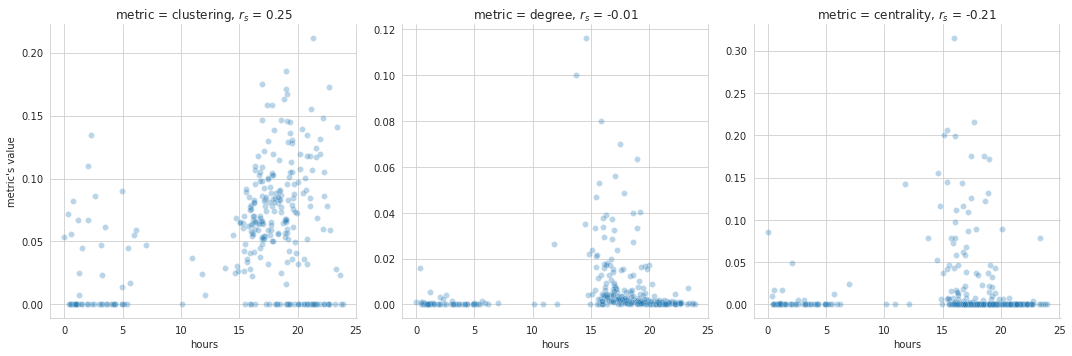

In [32]:
# Calculate Spearman correlation hours and metrics
scorr = ap_metrics.drop('dt', axis=1).corr('spearman').loc['hours']
# Create df for visualisation
ap_viz = ap_metrics.drop('dt', axis=1).reset_index().melt(id_vars=['index', 'hours'], var_name='metric')
# Visualisation
sns.set_style('whitegrid')
sp = sns.relplot(data=ap_viz, x='hours', y='value', col='metric', facet_kws={'sharey': False, 'sharex': True}, alpha=0.3)
# Modify labels
sp.set_ylabels("metric's value")
# Modify axes' titles to include correlation
axes = sp.fig.axes
for ax in axes:
    current_title = ax.get_title()
    metric_name = current_title.split(' ')[2]
    title = f'{current_title}, $r_{{s}}$ = {round(scorr[metric_name], 2)}'
    ax.set_title(title)
plt.show()

### Results interpretation
Overall, we see weak to none correlations between median times and metrics calculated from graph:
1. Clustering $r_{s} = 0.25$
1. Centrality $r_{s} = -0.21$
1. Degree $r_{s} = -0.01$

Let's remember what those metrics are and try interpreting the results.

#### Clustering coefficient
Clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together. It is typically defined as the fraction of pairs of a node's neighbors that are also connected to each other. For weighted graphs, there are several ways to define clustering. The one used here is defined as the geometric average of the subgraph edge weights (refer to NetworkX doc [here](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html#r880ab2ccc448-1)).

Here, we observe weak positive correlation ($r_{s} = 0.25$) so there is a very slight tendency for airports with higer clustering coefficient to be infected later than with the lower one. One possible reason for this could be that the airports with high clustering coefficients have stronger internal connections, meaning that there are many flights between the airports within the cluster, but relatively fewer flights to airports outside of the cluster. This would make it more difficult for the infection to spread to the cluster and reach the airport in question.

#### Shortest-path betweenness centrality
For every pair of vertices in a connected graph, there exists at least one shortest path between the vertices. The betweenness centrality for each vertex is the number of these shortest paths that pass through the vertex. More on calculation we used could be found in the NetworkX documentation [here](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality). 

We see weak negative correlation ($r_{s} = -0.21$) with hours before aiprort infection. This could be because airports with higher betweenness centrality are likely to have more flights going through them, providing multiple pathways for the infection to spread. Additionally, if a node is central in the network, it's more likely to be connected to other infected nodes and therefore more likely to be infected as the simulation progresses.


#### Degree
It is a measure of the number of connections it has to other nodes, for weighted graph it is calculated as the sum of the edge weights adjacent to the node. 

A near-zero correlation ($r_{s} = -0.01$) between degree and median infection time in your simulation suggests that the number of connections a node has does not have a significant effect on the time it takes for the airport to become infected. There could be various reasons for this, one possibility is that the infection spread in the network is not solely determined by the number of connections a node has, but rather by other factors such as the nature of the connections, the properties of the nodes, or the dynamics of the spreading process.


